In [5]:
%pip install tiledbsoma
%pip install cellxgene-census gget


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 137.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.1
    Uninstalling wrapt-2.0.1:
      Successfully uninstalled wrapt-2.0.1
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take int

In [ ]:
# Install dependencies
!pip install torch-geometric
%pip install PyTDC --no-deps
%pip install accelerate datasets evaluate fuzzywuzzy biopython rdkit
import torch
print(f"Torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


In [1]:
# Load Data from TDC
from tdc.multi_pred import DTI
import pandas as pd
import numpy as np

print("Fetching KIBA from TDC...")
try:
    data_kiba = DTI(name = 'KIBA')
    split_kiba = data_kiba.get_split()
    train_data = split_kiba['train']
    val_data = split_kiba['valid']
    test_data = split_kiba['test']
    print(f"✅ Data Loaded. Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")
    print(train_data.head(2))
except Exception as e:
    print(f"Error loading data: {e}")


Downloading...


Fetching KIBA from TDC...


100%|██████████| 96.6M/96.6M [00:08<00:00, 11.9MiB/s]
Loading...
Done!


✅ Data Loaded. Train: 82360, Val: 11766, Test: 23531
         Drug_ID                                     Drug Target_ID  \
0  CHEMBL1087421  COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2    O14920   
1  CHEMBL1087421  COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2    P04626   

                                              Target     Y  
0  MSWSPSLTTQTCGAWEMKERLGTGGFGNVIRWHNQETGEQIAIKQC...  11.1  
1  MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...  11.1  


In [2]:
# Graph Conversion Utils
import torch
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx
import numpy as np

def smile_to_graph(smile):
    if not smile:
        return None
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        return None
    # Node Features
    features = []
    for atom in mol.GetAtoms():
        feature = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetTotalNumHs(),
        ]
        features.append(feature)
    x = torch.tensor(features, dtype=torch.float)
    # Edge Features
    edges = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edges.append((i, j))
        edges.append((j, i))
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    if edge_index.numel() == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    return Data(x=x, edge_index=edge_index)

# Test
test_smile = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
g = smile_to_graph(test_smile)
print(f"Test Graph: Nodes={g.num_nodes}, Edges={g.num_edges}")


Test Graph: Nodes=14, Edges=30


In [11]:
# Model Definition (GATNet & GCNNet)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_max_pool

class GATNet(nn.Module):
    def __init__(self, num_features_xd=3, n_output=1, num_features_xt=25,
                 output_dim=128, dropout=0.2):
        super(GATNet, self).__init__()
        # Graph Branch
        self.gcn1 = GATConv(num_features_xd, num_features_xd, heads=10, dropout=dropout)
        self.gcn2 = GATConv(num_features_xd * 10, output_dim, dropout=dropout)
        self.fc_g1 = nn.Linear(output_dim, output_dim)
        # Protein Branch
        self.embedding_xt = nn.Embedding(num_features_xt + 1, 128)
        self.conv_xt_global = nn.Conv1d(128, 32, 8)
        self.fc_xt_proj = nn.Linear(32, 128)
        # Fusion
        self.fc1 = nn.Linear(output_dim * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, n_output)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # Graph
        x = self.gcn1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.gcn2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = global_max_pool(x, batch)
        x = self.relu(self.fc_g1(x))
        # Protein
        target = data.target
        embedded_xt = self.embedding_xt(target)
        embedded_xt = embedded_xt.permute(0, 2, 1)
        conv_xt = self.relu(self.conv_xt_global(embedded_xt))
        xt = torch.max(conv_xt, dim=2)[0]
        xt = self.relu(self.fc_xt_proj(xt))
        # Concatenate
        xc = torch.cat((x, xt), 1)
        xc = self.dropout(self.relu(self.fc1(xc)))
        xc = self.dropout(self.relu(self.fc2(xc)))
        out = self.out(xc)
        return out


In [12]:
# Model Definition (GATNet & GCNNet)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_max_pool

class GATNet(nn.Module):
    def __init__(self, num_features_xd=3, n_output=1, num_features_xt=25,
                 output_dim=128, dropout=0.2):
        super(GATNet, self).__init__()
        # Graph Branch
        self.gcn1 = GATConv(num_features_xd, num_features_xd, heads=10, dropout=dropout)
        self.gcn2 = GATConv(num_features_xd * 10, output_dim, dropout=dropout)
        self.fc_g1 = nn.Linear(output_dim, output_dim)
        # Protein Branch
        self.embedding_xt = nn.Embedding(num_features_xt + 1, 128)
        self.conv_xt_global = nn.Conv1d(128, 32, 8)
        self.fc_xt_proj = nn.Linear(32, 128)
        # Fusion
        self.fc1 = nn.Linear(output_dim * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, n_output)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # Graph
        x = self.gcn1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.gcn2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = global_max_pool(x, batch)
        x = self.relu(self.fc_g1(x))
        # Protein
        target = data.target
        embedded_xt = self.embedding_xt(target)
        embedded_xt = embedded_xt.permute(0, 2, 1)
        conv_xt = self.relu(self.conv_xt_global(embedded_xt))
        xt = torch.max(conv_xt, dim=2)[0]
        xt = self.relu(self.fc_xt_proj(xt))
        # Concatenate
        xc = torch.cat((x, xt), 1)
        xc = self.dropout(self.relu(self.fc1(xc)))
        xc = self.dropout(self.relu(self.fc2(xc)))
        out = self.out(xc)
        return out


In [13]:
# Dataset Class
from torch.utils.data import Dataset
from tqdm import tqdm

class GraphDTADataset(Dataset):
    def __init__(self, data_df, target_vocab, target_max_len=1000):
        self.data_df = data_df
        self.target_vocab = target_vocab
        self.target_max_len = target_max_len

        print("Preprocessing Graphs...")
        self.drug_graphs = {}
        # Drug column usually 'Drug', Protein 'Target', Label 'Y'
        # Create unique drug cache
        unique_drugs = data_df['Drug'].unique()
        for smile in tqdm(unique_drugs):
            try:
                g = smile_to_graph(smile)
                if g is not None:
                    self.drug_graphs[smile] = g
            except:
                pass

        # Filter valid
        self.valid_data = []
        for idx, row in data_df.iterrows():
            smile = row['Drug']
            if smile in self.drug_graphs:
                self.valid_data.append(row)
        print(f"Valid samples: {len(self.valid_data)}/{len(data_df)}")

    def encode_protein(self, seq):
        indices = [self.target_vocab.get(c, 0) for c in str(seq)]
        if len(indices) < self.target_max_len:
            indices += [0] * (self.target_max_len - len(indices))
        else:
            indices = indices[:self.target_max_len]
        return torch.tensor(indices, dtype=torch.long)

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        row = self.valid_data[idx]
        smile = row['Drug']
        prot_seq = row['Target']
        y = row['Y']

        data = self.drug_graphs[smile]
        data.target = self.encode_protein(prot_seq).unsqueeze(0)
        data.y = torch.tensor([float(y)], dtype=torch.float)
        return data


In [16]:
# Training Setup
from torch_geometric.loader import DataLoader

# Build Vocab
unique_chars = set()
for seq in train_data['Target']:
    unique_chars.update(str(seq))
target_vocab = {c: i+1 for i, c in enumerate(sorted(list(unique_chars)))}
print(f"Vocab size: {len(target_vocab)}")

# Init Datasets
train_dataset = GraphDTADataset(train_data, target_vocab)
val_dataset = GraphDTADataset(val_data, target_vocab)
# test_dataset = GraphDTADataset(test_data, target_vocab)

train_loader = DataLoader(train_dataset, batch_size=256*4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256*4, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATNet(num_features_xt=len(target_vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

print(f"Model: GATNet on {device}")


Vocab size: 20
Preprocessing Graphs...


100%|██████████| 2068/2068 [00:01<00:00, 1672.05it/s]


Valid samples: 82360/82360
Preprocessing Graphs...


100%|██████████| 1850/1850 [00:01<00:00, 1701.62it/s]


Valid samples: 11766/11766
Model: GATNet on cuda


In [17]:
# Training Loop
epochs = 20
best_loss = float('inf')

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1), data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs

    avg_loss = total_loss / len(train_dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output.view(-1), data.y.view(-1))
            val_loss += loss.item() * data.num_graphs

    avg_val_loss = val_loss / len(val_dataset)
    print(f"Epoch {epoch+1}: Train MSE={avg_loss:.4f}, Val MSE={avg_val_loss:.4f}")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), "best_graph_model.pth")
        print("  Saved Best Model")


Epoch 1: Train MSE=33.0621, Val MSE=2.9804
  Saved Best Model
Epoch 2: Train MSE=1.1493, Val MSE=1.7995
  Saved Best Model
Epoch 3: Train MSE=0.9401, Val MSE=1.5232
  Saved Best Model
Epoch 4: Train MSE=0.8983, Val MSE=1.5552
Epoch 5: Train MSE=0.8785, Val MSE=1.3977
  Saved Best Model
Epoch 6: Train MSE=0.8682, Val MSE=1.4207
Epoch 7: Train MSE=0.8603, Val MSE=1.3732
  Saved Best Model
Epoch 8: Train MSE=0.8527, Val MSE=1.4298
Epoch 9: Train MSE=0.8409, Val MSE=1.5829
Epoch 10: Train MSE=0.8428, Val MSE=1.6737
Epoch 11: Train MSE=0.8238, Val MSE=1.5688
Epoch 12: Train MSE=0.8130, Val MSE=1.8031
Epoch 13: Train MSE=0.8112, Val MSE=1.9898
Epoch 14: Train MSE=0.8120, Val MSE=2.0337
Epoch 15: Train MSE=0.8099, Val MSE=2.1069
Epoch 16: Train MSE=0.7993, Val MSE=2.1380
Epoch 17: Train MSE=0.7922, Val MSE=2.1768
Epoch 18: Train MSE=0.7937, Val MSE=2.1506
Epoch 19: Train MSE=0.7992, Val MSE=2.3708
Epoch 20: Train MSE=0.7871, Val MSE=2.8744


Preprocessing Graphs...


100%|██████████| 2021/2021 [00:04<00:00, 500.76it/s]


Valid samples: 23531/23531
Loaded best_graph_model.pth
Test MSE: 1.4143
Test CI (Spearman): 0.4592


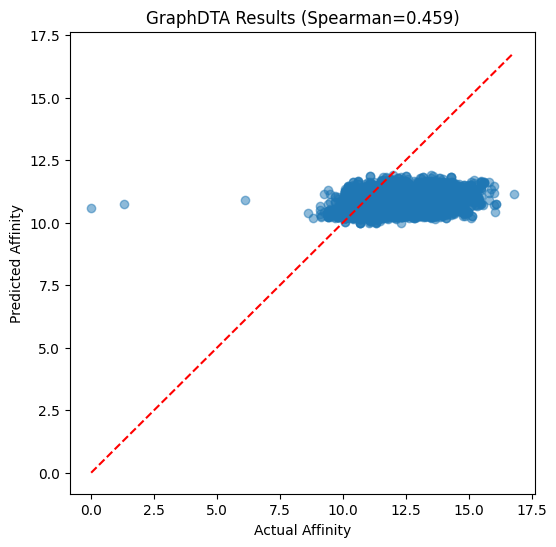

In [26]:
# Evaluation on Test Set
from tdc import Evaluator
import matplotlib.pyplot as plt
import os
from torch_geometric.loader import DataLoader

# Re-initialize test_dataset and test_loader, assuming target_vocab and test_data are available
# from previous cells.
# Init Test Dataset
test_dataset = GraphDTADataset(test_data, target_vocab)
test_loader = DataLoader(test_dataset, batch_size=256*4, shuffle=False)

# Load Best Model
path = 'best_graph_model.pth'
if os.path.exists(path):
    model.load_state_dict(torch.load(path))
    model.eval()
    print(f'Loaded {path}')
else:
    print('Model not found')

predictions = []
labels = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = model(data)
        predictions.extend(output.view(-1).cpu().numpy())
        labels.extend(data.y.view(-1).cpu().numpy())

# Metrics
eval_mse = Evaluator(name = 'MSE')
mse = eval_mse(labels, predictions)
eval_ci = Evaluator(name = 'spearman') # Changed from 'c_index' to 'spearman'
ci = eval_ci(labels, predictions)

print(f'Test MSE: {mse:.4f}')
print(f'Test CI (Spearman): {ci:.4f}') # Updated print statement

# Plot
plt.figure(figsize=(6,6))
plt.scatter(labels, predictions, alpha=0.5)
plt.plot([min(labels), max(labels)], [min(labels), max(labels)], 'r--')
plt.xlabel('Actual Affinity')
plt.ylabel('Predicted Affinity')
plt.title(f'GraphDTA Results (Spearman={ci:.3f})') # Updated title
plt.show()
